# Naive Bayes Example
## 1.0 Background
This is a walk-through in using the Naive Bayes (NB) Classifier in the file `Naive_Bayes_Model.py`.  

The classifier implemented in 'Naive_Bayes_Model.py' called 'NB_Classifier' has two important characteristics:
1. this NB implementation can combine data from a mixture of continuous data modeled as Conditional Linear Gaussians, and multinomial data modeled as a Tabular Conditional Probability Distributions.  
2. this NB implementation can be trained and tested with data sets that have missing data in the features, $x_i$, and outcome, $y$.

(Note, the tabular CPD for modeling multinomial data can also be used to model binomial data.)

In [1]:
import numpy as np
import scipy.stats
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import expon 
from Naive_Bayes_Model import NB_Classifier

## 2.0 Data Set
Here we generate a fake date set with continuous and binomial variables.  

Some of the features, $x_i$, are predictive and others are just random.  

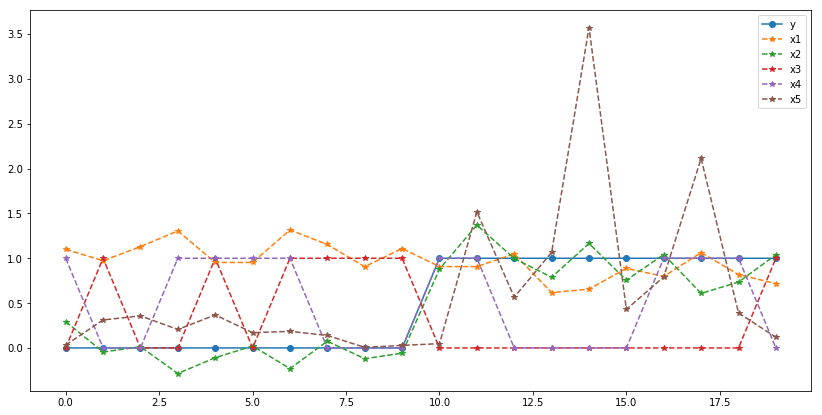

In [2]:
# set a random seed so that we get same results every run
np.random.seed(42)

# define outcome variable 
y = np.concatenate((np.zeros(10),np.ones(10)), axis=0) 

# features, predictive variables
x1 = np.random.normal(loc=1, scale=0.2, size=20) # random
x2 = y + np.random.normal(loc=0.0, scale=0.2, size=20) # non-random
x3 = np.concatenate((np.random.binomial(n=1, p=0.85, size = 10), # non-random
                     np.random.binomial(n=1, p=0.15, size = 10)), axis = 0)
x4 = np.random.binomial(n=1, p=0.5, size = 20) # random
x5 = np.concatenate((expon.rvs(scale = 0.25,  size = 10),
                    expon.rvs(scale = 1.5,  size = 10)), axis = 0)


fig, ax = plt.subplots(1,1, figsize = (14,7))
ax.plot(np.arange(20), y, 'o-', label = 'y') 
ax.plot(np.arange(20), x1, '*--', label = 'x1')
ax.plot(np.arange(20), x2, '*--', label = 'x2')
ax.plot(np.arange(20), x3, '*--', label = 'x3')
ax.plot(np.arange(20), x4, '*--', label = 'x4')
ax.plot(np.arange(20), x5, '*--', label = 'x5')

plt.legend()
plt.show()

A pandas dataframe is generated from our data.  

In [3]:
d = {'y': y, 'x1': x1, 'x2': x2, 'x3': x3, 'x4': x4, 'x5': x5}

train_df = pd.DataFrame(d)

train_df.head()

,x1,x2,x3,x4,x5,y
0,1.099343,0.293130,0,1,0.031843,0.0
1,0.972347,-0.045155,1,0,0.312282,0.0
2,1.129538,0.013506,0,0,0.357598,0.0
3,1.304606,-0.284950,0,1,0.205972,0.0
4,0.953169,-0.108877,1,1,0.368472,0.0


Some values are replaced with missing data in this step.  

In [4]:
# add NaNs to the data
train_df['y'].loc[3] = np.nan
train_df['y'].loc[7] = np.nan
train_df['x1'].loc[0] = np.nan
train_df['x1'].loc[19] = np.nan
train_df['x2'].loc[8] = np.nan
train_df['x2'].loc[18] = np.nan
train_df['x3'].loc[8] = np.nan
train_df['x3'].loc[18] = np.nan
train_df['x4'].loc[18] = np.nan
train_df['x5'].loc[1] = np.nan

train_df.head()

/home/jeff/anaconda2/envs/pytorch_2/lib/python2.7/site-packages/pandas/core/indexing.py:190: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._setitem_with_indexer(indexer, value)


,x1,x2,x3,x4,x5,y
0,NaN,0.293130,0.0,1.0,0.031843,0.0
1,0.972347,-0.045155,1.0,0.0,NaN,0.0
2,1.129538,0.013506,0.0,0.0,0.357598,0.0
3,1.304606,-0.284950,0.0,1.0,0.205972,NaN
4,0.953169,-0.108877,1.0,1.0,0.368472,0.0


In [5]:
# Create correlation matrix
corr_matrix = train_df.corr().abs()

corr_matrix

,x1,x2,x3,x4,x5,y
x1,1.000000,0.699207,0.403418,0.221725,0.478127,0.563594
x2,0.699207,1.000000,0.464156,0.118602,0.527276,0.930618
x3,0.403418,0.464156,1.000000,0.235702,0.368563,0.492659
x4,0.221725,0.118602,0.235702,1.000000,0.052695,0.055556
x5,0.478127,0.527276,0.368563,0.052695,1.000000,0.484058
y,0.563594,0.930618,0.492659,0.055556,0.484058,1.000000


## 3.0 Naive Bayes Algorithm   
Naive Bayes takes the following graphical form:  

<img src="naive_bayes.png">  

We can use the chain rule for a Bayesian Network to write this as:  

$$P(y_i, x_1, ..., x_n) = P(y_i)*P(x_1 \mid y_i) * ... * P(x_n \mid y_i)$$  

If we want to know to which class ,$y_i$, an observaion is likely from, we find the class for which the observation's input variables have the highest probability. This is described by the following equation:   

$$y = argmax_{y_i} P(y_i) \prod^{n}_{j=1} P(x_j \mid y_i)$$  


### 3.1 Train the model
Using our fake data set we will train our NB classifier.  

We will start by defining the variables that are continuous or multinomial, then supply this information to the model.  

Followiong this step, we call the methods for training our model.  

In [6]:
### Compute Naive Bayes
gaussian_variables = ['x1','x2']
multinomial_variables = ['x3','x4']
exponential_variables = ['x5']
outcome_variable = 'y'

# Define our model
my_NB = NB_Classifier(train_df, outcome_variable, gaussian_variables, multinomial_variables, exponential_variables)

# compute the prevaluence of each outcome class
my_NB.train_prevalence()

# compute the Conditional Linear Gaussian parameters for Gaussian variables
my_NB.train_CLG_variables()

# compute the Conditional Linear Gaussian parameters for exponential variables
my_NB.train_Exponential_variables()

# compute the Tabular CPD parameters for our binomial variables
my_NB.train_multinomial_variables()

### 3.2 Test the model
The model trains quickly given this small data set.  

We will review the trained parameters, but first let's call the methods for testing the model on our training data:  

In [7]:
# perform the inference on each observation
my_NB.inference()

# generate the results
my_NB.compute_results()

Inferencing on Training Data
algorithm accuracy: 0.94444


In [8]:
a = np.array([[1,2,-np.inf],[2,3,4],[4,5,6]])

a = np.where(a==-np.inf, 55, a)

print a

for row in a:
    row = np.where(row==-np.inf, 55, row) 
    print row

[[ 1.  2. 55.]
 [ 2.  3.  4.]
 [ 4.  5.  6.]]
[ 1.  2. 55.]
[2. 3. 4.]
[4. 5. 6.]


As expected, these results show that the model works exceptionally well on the training data.  

Let's generate a new data set to see how the model performs on new data.  

## 4.0 Inference with model on new data  
Here we will generate a new set of observations and inference with the previously trained model.  

The parameters of this new data set have been tweaked a bit to make things more difficult.  

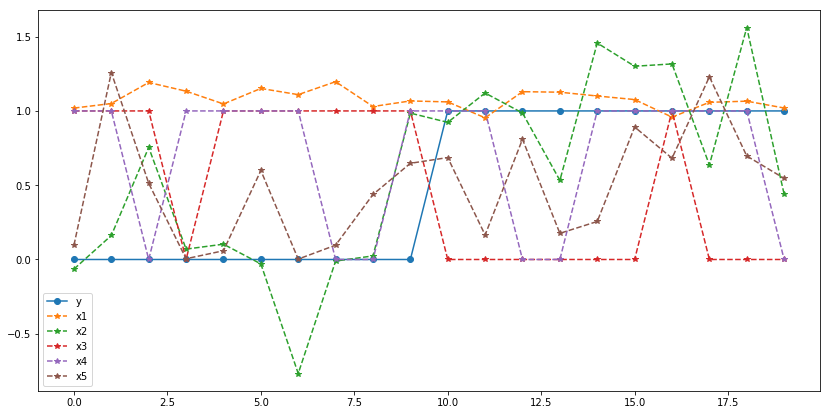

In [9]:
# New data set
y = np.concatenate((np.zeros(10),np.ones(10)), axis=0) 
x1 = np.random.normal(loc=1.1, scale=0.1, size=20) # random
x2 = y + np.random.normal(loc=0.0, scale=0.4, size=20) # non-random
x3 = np.concatenate((np.random.binomial(n=1, p=0.70, size = 10), # non-random
                     np.random.binomial(n=1, p=0.30, size = 10)), axis = 0)
x4 = np.random.binomial(n=1, p=0.5, size = 20) # random
x5 = np.concatenate((expon.rvs(scale = 0.55,  size = 10),
                    expon.rvs(scale = 0.65,  size = 10)), axis = 0)

fig, ax = plt.subplots(1,1, figsize = (14,7))
ax.plot(np.arange(20), y, 'o-', label = 'y') 
ax.plot(np.arange(20), x1, '*--', label = 'x1')
ax.plot(np.arange(20), x2, '*--', label = 'x2')
ax.plot(np.arange(20), x3, '*--', label = 'x3')
ax.plot(np.arange(20), x4, '*--', label = 'x4')
ax.plot(np.arange(20), x5, '*--', label = 'x5')

plt.legend()
plt.show()

In [10]:
# generate a dataframe
d = {'y': y, 'x1': x1, 'x2': x2, 'x3': x3, 'x4': x4, 'x5': x5}
test_df = pd.DataFrame(d)

# add NaNs to the data
test_df['y'].loc[5] = np.nan
test_df['y'].loc[1] = np.nan
test_df['x1'].loc[7] = np.nan
test_df['x1'].loc[18] = np.nan
test_df['x2'].loc[9] = np.nan
test_df['x2'].loc[17] = np.nan
test_df['x3'].loc[7] = np.nan
test_df['x3'].loc[0] = np.nan
test_df['x4'].loc[10] = np.nan

test_df.head()

,x1,x2,x3,x4,x5,y
0,1.019151,-0.064514,NaN,1.0,0.096962,0.0
1,1.049824,0.161620,1.0,1.0,1.258527,NaN
2,1.191540,0.754474,1.0,0.0,0.512872,0.0
3,1.132875,0.069831,0.0,1.0,0.005082,0.0
4,1.047024,0.103020,1.0,1.0,0.058848,0.0


### 4.1 Inference on test data  
In this step we supply a new dataframe to the model by passing this dataframe into the `inference()` method.  

In [11]:
# perform the inference on each observation
my_NB.inference(test_df)

# generate the results
my_NB.compute_results()

Inferencing on Test Data
algorithm accuracy: 0.88889


Here we see the results are slightly less accurate, owing to the modifications made in the new testing data set.  

## 4.0 View parameters of our trained NB model
Here we look at the data generated when calling this model.  

### 4.1 Model training
The following attributes are generated when a model is trained by calling the methods `train_prevalence()`, `train_continuous_variables()`, and `train_multinomial_variables()`:

* `prevalence_params`: prevalence of each of the outcome categores/classes.  
* `CLG_list`: parameters [mean, std] for each conditional linear gaussian of the continuous variables.  
* `CPD_list`: the tabular CPDs of the Gaussian variables.  
* `Expon_list`: the tabular CPDs of the exponential variables.  


In [12]:
print 'prevalence_params:'
print my_NB.prevalence_params

print '\nCLG_list:'
print my_NB.CLG_list

print '\nCPD_list:'
print my_NB.CPD_list

print '\nExpon_list:'
print my_NB.Expon_list

prevalence_params:
{'0.0': 0.4444444444444444, '1.0': 0.5555555555555556}

CLG_list:
{'x2': {'0.0': [-0.01624990825451297, 0.16074780921342327], '1.0': [0.9606026530602662, 0.23078572999132876]}, 'x1': {'0.0': [1.04838378224044, 0.14485125189416673], '1.0': [0.8556826967891367, 0.15338282296296143]}}

CPD_list:
{'x3': {'0.0': {'0.0': 0.42857142857142855, '1.0': 0.5714285714285714}, '1.0': {'0.0': 0.8888888888888888, '1.0': 0.1111111111111111}}, 'x4': {'0.0': {'0.0': 0.5, '1.0': 0.5}, '1.0': {'0.0': 0.5555555555555556, '1.0': 0.4444444444444444}}}

Expon_list:
{'x5': {'0.0': [0.006436943497528432, 0.15756533839115924], '1.0': [0.047900521939580734, 1.0135657823906181]}}


### 4.2 Model inferencing
The next set of attributes are produced when the `inference()` method is called for inference.  

* `log_class_probabilities`: the ln of the probability that an observation belongs to each outcome class (in NB models these probabilities are not interpreted exactly).   
* `prediction`: the outcome class predicted by the BM model for each observation.  

In [13]:
print 'log_class_probabilities:'
print my_NB.log_class_probabilities

print '\nprediction:'
print my_NB.prediction

log_class_probabilities:
{'0.0': array([ -2.52208468, -11.3330342 , -19.73492264,  -3.45548089,
        -3.18449982,  -6.63376047, -15.19120228,  -2.10359519,
        -5.12887221,  -6.24169627, -25.13290869, -31.2357332 ,
       -29.52358134, -11.30617635, -48.72294177, -44.0461796 ,
       -43.6955467 , -10.16936561, -57.39603531, -11.32762356]), '1.0': array([-14.32438038, -13.90322371,  -8.37717784, -13.24897017,
       -13.6618198 , -17.99857792, -36.2127415 , -11.79116184,
       -15.03197852,  -5.97238997,  -3.18197736,  -2.99750058,
        -4.73909858,  -6.72709881,  -7.38459009,  -6.2097978 ,
        -7.00326929,  -4.35760615,  -6.83789629,  -6.77566155])}

prediction:
['0.0', '0.0', '1.0', '0.0', '0.0', '0.0', '0.0', '0.0', '0.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0']


In [14]:
argmax = np.array([i for i in np.argmax(my_NB.log_class_probabilities.values(), axis=0)])
prediction = [my_NB.log_class_probabilities.keys()[i] for i in argmax]
print argmax
print prediction

[0 0 1 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1]
['0.0', '0.0', '1.0', '0.0', '0.0', '0.0', '0.0', '0.0', '0.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0']


### 4.1 Model results  
This last set of attributes are obtained once we call `compute_results()` method.  

* `ground_truth`: the true class of each observation in the data set.  

In [15]:
print 'ground_truth:'
print my_NB.ground_truth

ground_truth:
['0.0' 'nan' '0.0' '0.0' '0.0' 'nan' '0.0' '0.0' '0.0' '0.0' '1.0' '1.0'
 '1.0' '1.0' '1.0' '1.0' '1.0' '1.0' '1.0' '1.0']
